In [4]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

import gillespy2
from gillespy2.solvers.stochkit import StochKitSolver
from tsfresh.feature_extraction.settings import MinimalFCParameters
import numpy as np
import os

from dask.distributed import Client
#os.environ["STOCHKIT_HOME"] = '/home/jovyan/StochKit'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Define Model

In [5]:
model_doc = gillespy2.StochMLDocument.from_file("vilar_oscillator.xml")
vilar_model = model_doc.to_model("Vilar")
vilar_model.tspan = np.linspace(0, 100, 100)

## Define simulator function

In [6]:
def set_model_parameters(params, model):
    """ params - array, needs to have the same order as model.listOfParameters """
    for e, (pname, p) in enumerate(model.listOfParameters.items()):
        model.get_parameter(pname).set_expression(params[e])
    return model

# Here we use gillespy2 numpy solver, so performance will be quite slow for this model
def simulator(params, model):
    
    from gillespy2.solvers.numpy.ssa_solver import MaxStateReached
    from sciope.stochmet.stochmet import EventFired
    
    model_update = set_model_parameters(params, model)
    num_trajectories = 1 #TODO: howto handle ensembles

    res = model_update.run(solver=StochKitSolver, show_labels=False, number_of_trajectories=num_trajectories)
    tot_res = res[0][:,1:] #should not contain timepoints
    
    return np.array(tot_res)

In [7]:
vilar_model.run(solver=StochKitSolver)

[{'time': array([  0.       ,   1.0204082,   2.0408163,   3.0612245,   4.0816327,
           5.1020408,   6.122449 ,   7.1428571,   8.1632653,   9.1836735,
          10.204082 ,  11.22449  ,  12.244898 ,  13.265306 ,  14.285714 ,
          15.306122 ,  16.326531 ,  17.346939 ,  18.367347 ,  19.387755 ,
          20.408163 ,  21.428571 ,  22.44898  ,  23.469388 ,  24.489796 ,
          25.510204 ,  26.530612 ,  27.55102  ,  28.571429 ,  29.591837 ,
          30.612245 ,  31.632653 ,  32.653061 ,  33.673469 ,  34.693878 ,
          35.714286 ,  36.734694 ,  37.755102 ,  38.77551  ,  39.795918 ,
          40.816327 ,  41.836735 ,  42.857143 ,  43.877551 ,  44.897959 ,
          45.918367 ,  46.938776 ,  47.959184 ,  48.979592 ,  50.       ,
          51.020408 ,  52.040816 ,  53.061224 ,  54.081633 ,  55.102041 ,
          56.122449 ,  57.142857 ,  58.163265 ,  59.183673 ,  60.204082 ,
          61.22449  ,  62.244898 ,  63.265306 ,  64.285714 ,  65.306122 ,
          66.326531 ,  67.3469

## Define parameter sampler

In [22]:
from sciope.utilities.priors import uniform_prior
default_param = np.array(list(vilar_model.listOfParameters.items()))[:,1]
bound = []
for exp in default_param:
    bound.append(float(exp.expression))
    
bound = np.array(bound)

sampler = uniform_prior.UniformPrior(bound*0.5, bound*5.0)

## Start local cluster using dask client

In [2]:
c = Client('192.168.1.6:8786')
c

Client Scheduler: tcp://192.168.1.6:8786 Dashboard: http://192.168.1.6:8787/status,Cluster Workers: 32 Cores: 64 Memory: 132.36 GB


In [4]:
from dask.distributed import get_client
get_client()

ValueError: No global client found and no address provided

## Initiate StochMET

In [23]:
from sciope.stochmet.stochmet import StochMET

#Arg: "model" enables us the change which model to be used
simulator2 = lambda x : simulator(x, model=vilar_model)

#lets use this set of features:
default_fc_params = {'mean': None,
                     'variance': None,
                     'skewness': None,
     'agg_autocorrelation': [{'f_agg': 'mean', 'maxlag': 5},
 {'f_agg': 'median', 'maxlag': 5},
 {'f_agg': 'var', 'maxlag': 5}]}


met = StochMET(simulator=simulator2, sampler=sampler, features=default_fc_params)

## Run parameter sweep (will persist and running in background)

In [13]:
print(vilar_model.listOfSpecies.keys())

#Lets extract features for only 'Ma', 'Mr', 'C', 'A' and 'R'
idx_species = [7,8]

odict_keys(['Da', 'Da_prime', 'Ma', 'Dr', 'Dr_prime', 'Mr', 'C', 'A', 'R'])


In [24]:
met.compute(n_points=1000, n_species=idx_species)

## Explore the result
Here we will explore parameter points expressed in feature space using a dimension reduction method. User can interact with points and label points according to different model behavior

In [25]:
#First lets add some appropiate information about the model and features for interative purposes
met.data.configurations['listOfParameters'] = list(vilar_model.listOfParameters.keys())
met.data.configurations['listOfSpecies'] = list(vilar_model.listOfSpecies.keys())
met.data.configurations['listOfSummaries'] = met.summaries.features
met.data.configurations['timepoints'] = vilar_model.tspan

<IPython.core.display.Javascript object>


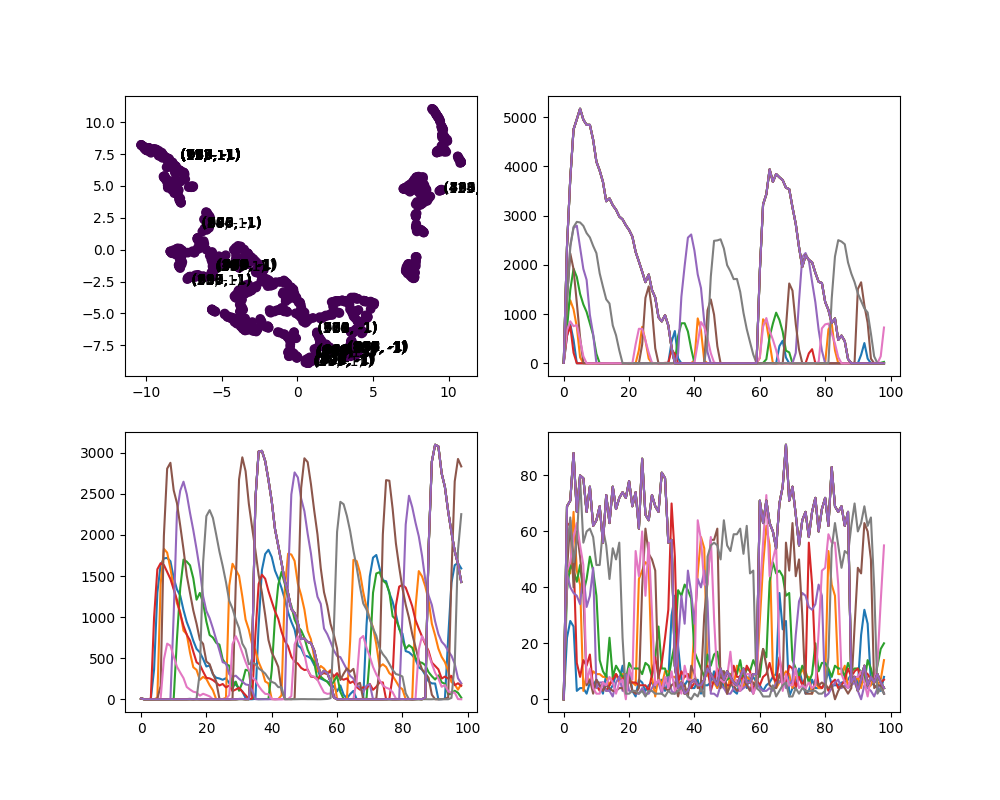

Button(description='Clear all', style=ButtonStyle())

Button(description='Submit', style=ButtonStyle())

IntSlider(value=0, max=10, min=-1)

Dropdown(description='Species plot 1', options={'Da': 0, 'Da_prime': 1, 'Ma': 2, 'Dr': 3, 'Dr_prime': 4, 'Mr':…

Dropdown(description='Species plot 2', index=1, options={'Da': 0, 'Da_prime': 1, 'Ma': 2, 'Dr': 3, 'Dr_prime':…

Dropdown(description='Species plot 3', index=2, options={'Da': 0, 'Da_prime': 1, 'Ma': 2, 'Dr': 3, 'Dr_prime':…

Dropdown(description='Species plot 4', index=3, options={'Da': 0, 'Da_prime': 1, 'Ma': 2, 'Dr': 3, 'Dr_prime':…

Dropdown(description='Species plot 5', index=4, options={'Da': 0, 'Da_prime': 1, 'Ma': 2, 'Dr': 3, 'Dr_prime':…

Dropdown(description='Species plot 6', index=5, options={'Da': 0, 'Da_prime': 1, 'Ma': 2, 'Dr': 3, 'Dr_prime':…

Dropdown(description='Species plot 7', index=6, options={'Da': 0, 'Da_prime': 1, 'Ma': 2, 'Dr': 3, 'Dr_prime':…

Dropdown(description='Species plot 8', index=7, options={'Da': 0, 'Da_prime': 1, 'Ma': 2, 'Dr': 3, 'Dr_prime':…

Dropdown(description='Species plot 9', index=8, options={'Da': 0, 'Da_prime': 1, 'Ma': 2, 'Dr': 3, 'Dr_prime':…

,alpha_A,alpha_a_prime,alpha_r,alpha_r_prime,beta_a,beta_r,delta_ma,delta_mr,delta_a,delta_r,gamma_a,gamma_r,gamma_c,Theta_a,Theta_r
0,25.512706,586.826316,0.008156,61.279357,38.585728,7.375491,13.674714,0.405796,0.671328,0.171533,0.631171,0.986175,2.555670,55.426048,99.074645
1,40.865937,278.016279,0.014386,33.006906,29.374356,6.189901,10.285047,0.407949,1.277479,0.256019,1.106074,1.412132,2.590731,59.652159,96.546856
2,62.395173,399.589558,0.008376,61.238116,72.596443,4.563163,5.318558,0.663399,0.548306,0.111196,0.850015,0.535582,2.485935,69.214416,75.783193
3,59.876960,685.021636,0.007148,63.276061,64.886087,5.125389,13.775322,0.419671,0.654813,0.259633,1.102972,0.632312,1.511202,68.864099,82.367881
4,62.426054,273.927730,0.005036,40.768803,57.221462,4.409061,6.559503,0.696313,0.624686,0.234610,0.876999,0.835381,1.187544,57.660000,128.313484
5,61.933680,639.948020,0.013269,68.900398,49.786397,3.113238,12.696936,0.693294,0.967616,0.244400,0.973376,0.561140,1.091902,38.933687,117.352859
6,58.198496,589.273463,0.009426,48.264709,38.512014,4.338007,9.812228,0.531748,0.853594,0.157094,0.519082,1.124609,2.191586,61.875418,62.682417
7,47.310255,501.320177,0.006143,69.105940,36.425686,5.926108,12.051894,0.300651,1.298181,0.287313,1.367463,0.947337,1.907582,25.880625,143.076874
8,25.733444,424.985751,0.012527,37.333777,38.949608,3.715976,12.595613,0.589591,0.970545,0.155882,0.998422,1.227809,1.035300,68.675555,141.953646
9,41.455307,425.702392,0.011388,36.258411,67.884489,5.590868,9.663723,0.663309,1.286289,0.294167,0.603340,0.711355,1.417490,27.316500,76.728869


In [26]:
# Here we use UMAP for dimension reduction and collect the data from persited storage
met.explore(dr_method='umap', from_distributed=False)

## Once a few points has been added we can use Semi-supervised learning

In [ ]:
from sciope.models.label_propagation import LPModel
#here lets use the dimension reduction embedding as input data
data = met.dr_model.embedding_

model_lp = LPModel()
#train using basinhopping
model_lp.train(data, met.data.user_labels, min_=0.01, max_=10, niter=50)

In [ ]:
# just to vislualize the result we will map the label distribution to the user_labels (will enable us to see the LP model 
# output when using "explore")

user_labels = np.copy(met.data.user_labels)
met.data.user_labels = model_lp.model.label_distributions_[:,0]

In [ ]:
met.explore(dr_method='umap', from_distributed=False)

In [ ]:
met.data.user_labels = user_labels

In [15]:
from sciope.designs.latin_hypercube_sampling import LatinHypercube

In [17]:
import numpy as np
lhc = LatinHypercube(xmin=np.zeros(15), xmax=np.ones(15), seed_size=20)


2019-06-18 14:34:40,014 	 [INFO     | latin_hypercube_sampling.py:56] : Latin hypercube design in 15 dimensions initialized


In [80]:
import dask.array as da

test = da.from_delayed(lhc.generate(10000), shape=(10000,15), dtype=np.float)

In [50]:
test = test.persist()

In [7]:
import dask
dask.visualize

Delayed('generate-8e76333b-0327-42a9-a44c-b589738f173a')

In [18]:
test = lhc.generate(10000).persist()

In [132]:
test = da.from_delayed(test, shape=(10000, 15), dtype=np.float)

In [6]:
lhc._seed_size

15

In [113]:
for i in test:
    print(i.mean())

dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-

dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-

dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-

dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-

dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-

dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-

dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-

dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-

dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-

dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-

dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-

dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-

dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-

dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-

dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-

dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-

dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-

dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-

dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-

dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-

dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-

dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-

dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-

dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-

dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-

dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-

dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-

dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-

dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-

dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-

dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-

dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-

dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-

dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-

dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-

dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-

dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-

dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-

dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-

dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-

dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-

dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-

dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-

dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-

dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-

dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-

dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-

dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-

dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-

dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-

dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-

dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-

dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-

dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-aggregate, shape=(), dtype=float64, chunksize=()>
dask.array<mean_agg-

In [116]:
for i in test:
    print(i)

TypeError: Delayed objects of unspecified length are not iterable

In [8]:
import dask

def test1():
    return 1 + test1()

In [129]:
t = dask.delayed(test1)(shape=(5,), dtype=np.int)

In [138]:
x = np.array([1, 2, 3, -1, 5])
mx = np.ma.masked_array(x, mask=[0, 0, 0, 1, 0])

In [177]:
np.random.choice(x,2, replace=True)

array([1, 1])

In [162]:
1*0

0

In [178]:
t = [0,9]
t.pop([0,1])

TypeError: 'list' object cannot be interpreted as an integer

In [164]:
t

[0]

In [25]:
@dask.delayed
def factorial_recursive(n):
    # Base case: 1! = 1
    if n == 1:
        return 1

    # Recursive case: n! = n * (n-1)!
    else:
        return n * factorial_recursive(n-1).compute()

In [10]:
factorial_recursive = dask.delayed(factorial_recursive)

In [26]:
test = factorial_recursive(1000)

In [28]:
del test

In [21]:
dask.compute(test)

(Delayed('_inner-9a0db1881e435bf4f33f814f4c687873'),)

In [19]:
c.restart()

Client Scheduler: tcp://192.168.1.6:8786 Dashboard: http://192.168.1.6:8787/status,Cluster Workers: 32 Cores: 64 Memory: 132.36 GB
